<a href="https://colab.research.google.com/github/MutyaAnissa/Files/blob/main/Xgboost%2CSMOTEENN%2COptuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[I 2025-09-24 02:33:31,252] A new study created in memory with name: no-name-acd581d9-65e7-41c1-bcb4-d5d5b2e5609e
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:33:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:33:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:33:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-24 02:33:32,735] Trial 0 finished with value: 0.9930725713520907 and parameters: {'n_estimators': 286, 'max_depth': 11, 'learning_rate': 0.022189763556509257, 'subsample': 0.7913230956844506, 'colsamp

Best Trial:
{'n_estimators': 164, 'max_depth': 8, 'learning_rate': 0.24361646394895659, 'subsample': 0.6680177891380755, 'colsample_bytree': 0.7778227852395551, 'gamma': 0.4599929715733597, 'reg_alpha': 0.749211622565977, 'reg_lambda': 3.23693342547308, 'scale_pos_weight': 9}
=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       688
           1       0.93      1.00      0.96       758

    accuracy                           0.96      1446
   macro avg       0.96      0.96      0.96      1446
weighted avg       0.96      0.96      0.96      1446


Confusion Matrix:
[[632  56]
 [  3 755]]

ROC AUC: 0.9956510400687242


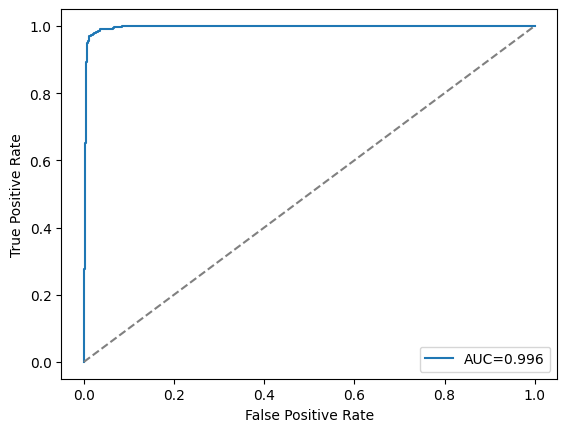

In [5]:
# === Instalasi library ===
!pip install optuna imbalanced-learn xgboost

# === Import Library ===
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier
import optuna

# === Contoh load dataset ===
df = pd.read_csv("stroke dataset.csv")  # ganti dengan datasetmu

# =========================
# 1. Missing Value Imputation (BMI dengan MICE)
# =========================
imputer = IterativeImputer(max_iter=10, random_state=42)
df[['bmi']] = imputer.fit_transform(df[['bmi']])

# =========================
# 2. Outlier Handling
# =========================
from scipy import stats
# Z-Score para BMI
z = np.abs(stats.zscore(df['bmi']))
df = df[(z < 3)]

# IQR para avg_glucose_level
Q1 = df['avg_glucose_level'].quantile(0.25)
Q3 = df['avg_glucose_level'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['avg_glucose_level'] >= (Q1 - 1.5 * IQR)) &
        (df['avg_glucose_level'] <= (Q3 + 1.5 * IQR))]

# =========================
# 3. Feature Engineering
# =========================
X = df.drop(columns=['stroke', 'id']) # Drop 'id' column
y = df['stroke']

categorical = ['gender', 'smoking_status']
numerical = ['age', 'avg_glucose_level', 'bmi']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical), # Added handle_unknown='ignore' for robustness
        ('num', StandardScaler(), numerical)],
    remainder='drop' # Changed from 'passthrough' to 'drop'
)

X = preprocessor.fit_transform(X)

# Seleksi fitur (misalnya pilih 8 terbaik)
selector = SelectKBest(score_func=f_classif, k=8)
X = selector.fit_transform(X, y)

# =========================
# 4. Balancing Dataset
# =========================
smote_enn = SMOTEENN(random_state=42)
X_res, y_res = smote_enn.fit_resample(X, y)

# =========================
# 5. Split Data
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, stratify=y_res, random_state=42
)

# =========================
# 6. Optimasi Hyperparameter dengan Optuna
# =========================
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 5.0),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 10),
        "eval_metric": "logloss",
        "random_state": 42
    }

    xgb = XGBClassifier(**params)
    scores = cross_val_score(
        xgb, X_train, y_train, cv=StratifiedKFold(n_splits=3), scoring="recall"
    )
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best Trial:")
print(study.best_trial.params)

# =========================
# 7. Training model terbaik
# =========================
best_params = study.best_trial.params
model = XGBClassifier(**best_params)
model.fit(X_train, y_train)

# =========================
# 8. Evaluasi
# =========================
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC:", roc_auc_score(y_test, y_proba))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()